# Predicción de respuesta a campaña de marketing bancario

En este proyecto utilizamos datos de una campaña de marketing directo de una entidad bancaria.
El objetivo es **predecir si un cliente contratará un depósito a plazo fijo** (`y` = "yes" / "no")
a partir de información sociodemográfica, financiera y del propio proceso de contacto comercial.

Trabajam con un modelo de **Regresión Logística**, adecuado para problemas de clasificación binaria,
y seguiremos el flujo:

1. Exploración y limpieza de datos.
2. Análisis exploratorio (EDA) univariante, bivariante y multivariante.
3. Preparación de datos para modelado (encoding + escalado).
4. Entrenamiento y ajuste de un modelo de Regresión Logística.
5. Evaluación del modelo y conclusiones de negocio.

## 1. Importar librerias

In [606]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pickle import dump
import os

os.makedirs("../models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)


RANDOM_STATE = 16
pd.set_option('display.max_columns', 200)

## 2. Carga de datos y limpieza inicial

En esta sección cargamos el dataset original y realizamos una primera revisión de:

- Dimensiones del dataset.
- Tipos de variables.
- Valores nulos y duplicados.

Adicionalmente, eliminamos algunas columnas que no utilizaremos en el modelo
(por ejemplo, `duration`, `emp.var.rate` y `nr.employed`), siguiendo las recomendaciones del profesor
y la documentación del dataset.

In [607]:
url = "https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv"
df = pd.read_csv(url, sep=';')

print('El dataframe contiene {} lineas y {} features.'.format(len(df), df.shape[1]))
print(df.columns)
df.head(5)

El dataframe contiene 41188 lineas y 21 features.
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [608]:
print(f"Dimensiones del dataframe: {df.shape}")
print(df.info())

Dimensiones del dataframe: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float

In [609]:
print(f"Valores unicos por columna: \n{df.nunique()}")

Valores unicos por columna: 
age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64


In [610]:
# Conteo de valores nulos

print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [611]:
nulls = df.isna().mean().sort_values(ascending=False)
dups = df.duplicated().sum()
print("Duplicados:", dups)
nulls.head(10)

Duplicados: 12


age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
dtype: float64

In [612]:
# Estadísticas descriptivas de columnas numéricas

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


## 2. Limpieza inicial del dataset

En esta parte elimino columnas que no aportan valor al análisis o al modelado
y gestiono los nulos más evidentes.

In [613]:
# Columnas poco útiles para un modelo de precio (identificadores, texto libre, fechas)
cols_to_drop = ['duration', 'emp.var.rate', 'nr.employed']

print("Shape antes del drop:", df.shape)

df = df.drop(columns=cols_to_drop)

print("Shape después del drop:", df.shape)
print("Columnas restantes:", list(df.columns))

# Revisar de nuevo nulos tras el drop
print("\nValores nulos por columna (tras drop):")
print(df.isnull().sum())

Shape antes del drop: (41188, 21)
Shape después del drop: (41188, 18)
Columnas restantes: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'y']

Valores nulos por columna (tras drop):
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
y                 0
dtype: int64


## 3. Análisis univariante

En esta parte analizamos la distribución de las variables numéricas y categóricas:

- Para **variables numéricas**, utilizamos histogramas y diagramas de caja para detectar asimetrías y posibles outliers.
- Para **variables categóricas**, analizamos la frecuencia de cada categoría y agrupamos en "Otros" cuando el número de niveles es muy elevado.

Esto nos permite entender mejor el perfil predominante de clientes en la base de datos.

### 3.1 Variables numéricas

En esta sección se analiza la distribución individual de cada variable numérica.

- age. Edad del cliente (numérico)
- campaign. Número de contactos realizados durante esta campaña al cliente (numérico)
- pdays. Número de días que transcurrieron desde la última campaña hasta que fue contactado (numérico)
- previous. Número de contactos realizados durante la campaña anterior al cliente (numérico)
- cons.price.idx. Índice de precios al consumidor. Indicador mensual (numérico)
- cons.conf.idx. Índice de confianza del consumidor. Indicador mensual (numérico)
- euribor3m. Tasa EURIBOR 3 meses. Indicador diario (numérico)

Variables numéricas: ['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045


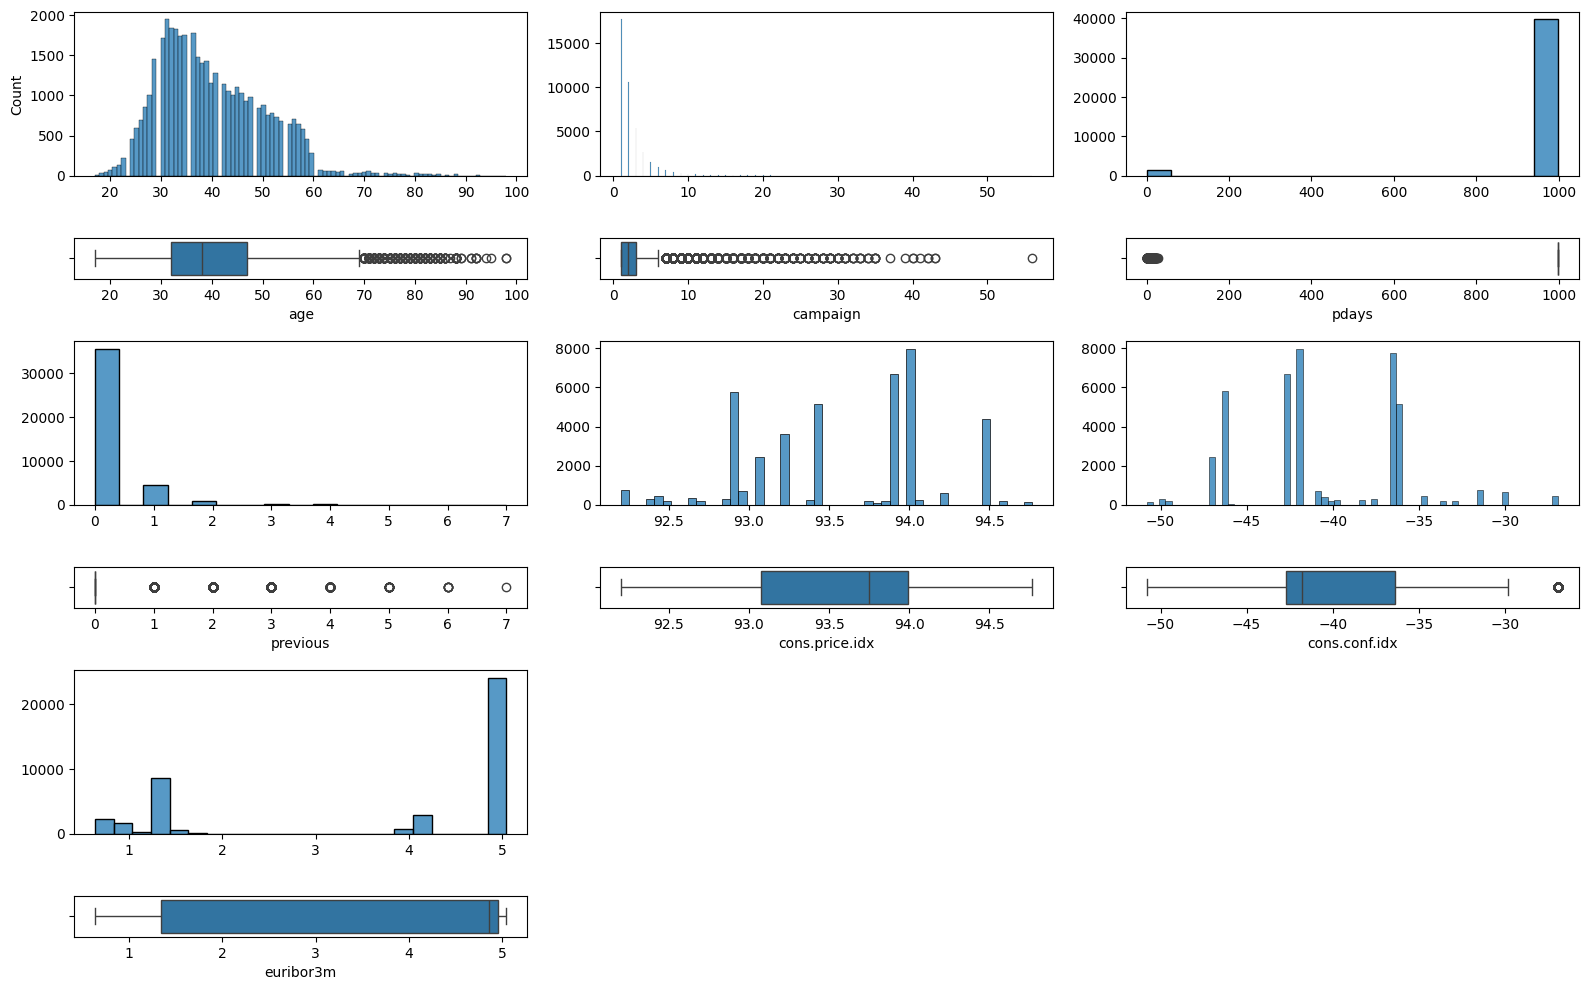

In [614]:
# Copia para EDA (posible filtrado de outliers extremos)
df_eda = df.copy()

fig, axis = plt.subplots(6, 3, figsize = (16, 10), gridspec_kw={'height_ratios': [4, 1, 4, 1, 4, 1]})

# Selección de variables numéricas
num_cols = df_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Variables numéricas:", num_cols)

# Resumen estadístico
display(df_eda[num_cols].describe().T)

# Crear una figura múltiple con histogramas y diagramas de caja

sns.histplot(ax = axis[0, 0], data = df_eda, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = df_eda, x = "age")

sns.histplot(ax = axis[0, 1], data = df_eda, x = "campaign").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_eda, x = "campaign")

sns.histplot(ax = axis[0, 2], data = df_eda, x = "pdays").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 2], data = df_eda, x = "pdays")

sns.histplot(ax = axis[2, 0], data = df_eda, x = "previous").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 0], data = df_eda, x = "previous")

sns.histplot(ax = axis[2, 1], data = df_eda, x = "cons.price.idx").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = df_eda, x = "cons.price.idx")

sns.histplot(ax = axis[2, 2], data = df_eda, x = "cons.conf.idx").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 2], data = df_eda, x = "cons.conf.idx")

sns.histplot(ax = axis[4, 0], data = df_eda, x = "euribor3m").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 0], data = df_eda, x = "euribor3m")

fig.delaxes(axis[4, 1])
fig.delaxes(axis[5, 1])

fig.delaxes(axis[4, 2])
fig.delaxes(axis[5, 2])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

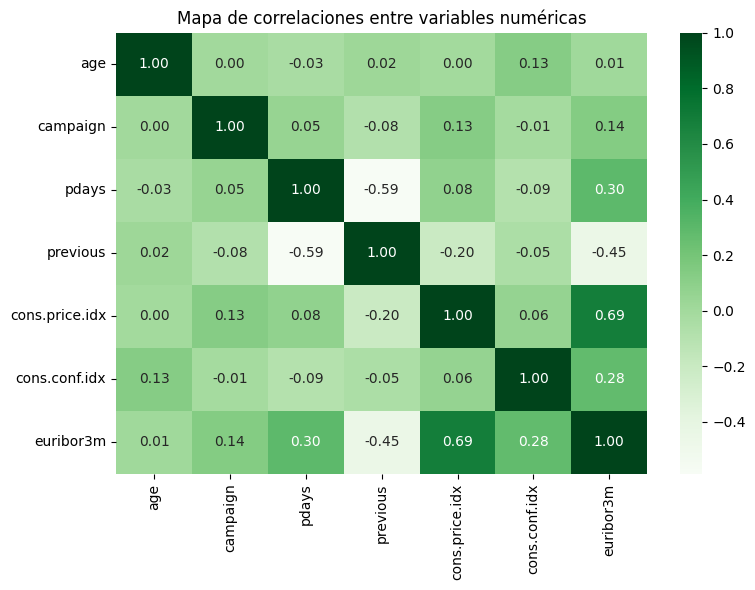

In [615]:
plt.figure(figsize=(8, 6))
corr_num = df_eda[num_cols].corr()

sns.heatmap(corr_num, annot=True, cmap='Greens', fmt=".2f")
plt.title("Mapa de correlaciones entre variables numéricas")
plt.tight_layout()
plt.show()

### 3.2 Variables categóricas

Ahora se analiza la distribución de las variables categóricas.

- job. Tipo de trabajo (categórico)
- marital. Estado civil (categórico)
- education. Nivel de educación (categórico)
- default. ¿Tiene crédito actualmente? (categórico)
- housing. ¿Tiene un préstamo de vivienda? (categórico)
- loan. ¿Tiene un préstamo personal? (categórico)
- contact. Tipo de comunicación de contacto (categórico)
- month. Último mes en el que se le ha contactado (categórico)
- day_of_week. Último día en el que se le ha contactado (categórico)
- poutcome. Resultado de la campaña de marketing anterior (categórico)
- y. TARGET. El cliente contrata un depósito a largo plazo o no (categórico)

In [616]:
# **Funcion que devuelve el dataframe sin los outliers y los limites de los features**

def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

#### Factorizar las variables categóricas

In [617]:
#En este caso, la variable objetivo se puede factorizar para realizar un analisis numerico

df_eda["y_n"] = pd.factorize(df_eda.y)[0]

y_transformation_rules = {row["y"]: row["y_n"] for index, row in df_eda[["y_n", "y"]].drop_duplicates().iterrows()}

#Guardamos la regla de transformacion en data/processed

with open("../data/processed/y_transformation_rules.json", "w") as f:
  json.dump(y_transformation_rules, f)

df_eda[["y","y_n"]].head()

,y,y_n
0,no,0
1,no,0
2,no,0
3,no,0
4,no,0


Columnas categóricas a analizar: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
'job' tiene 12 categorías -> se muestra top 10 + 'Otros'.


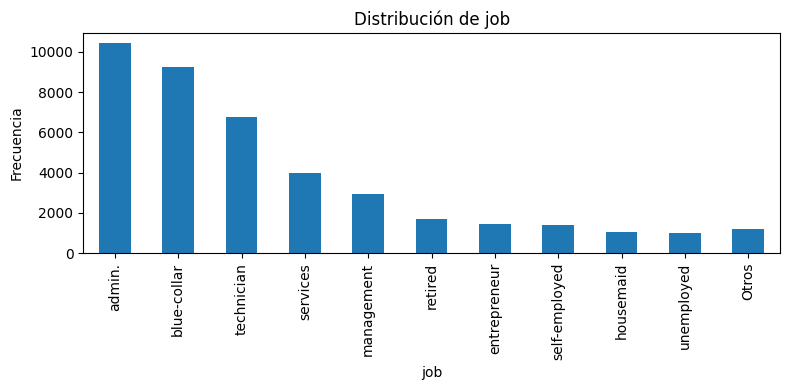

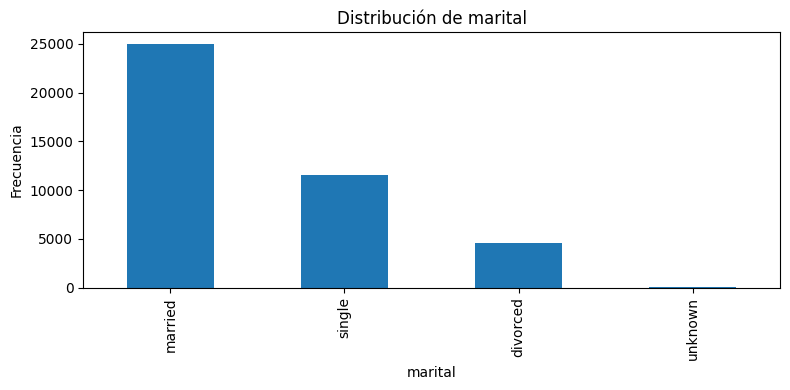

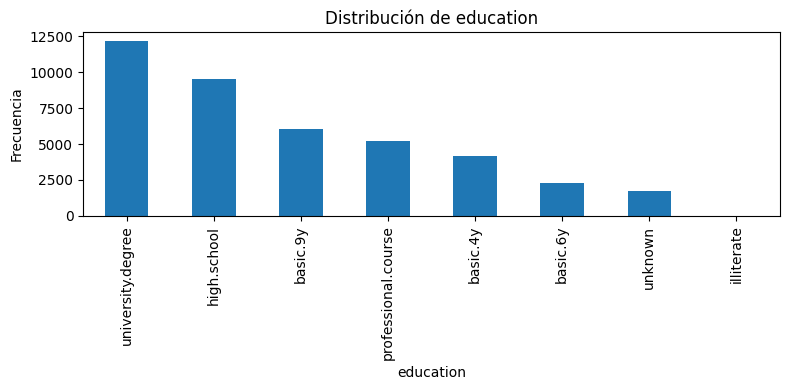

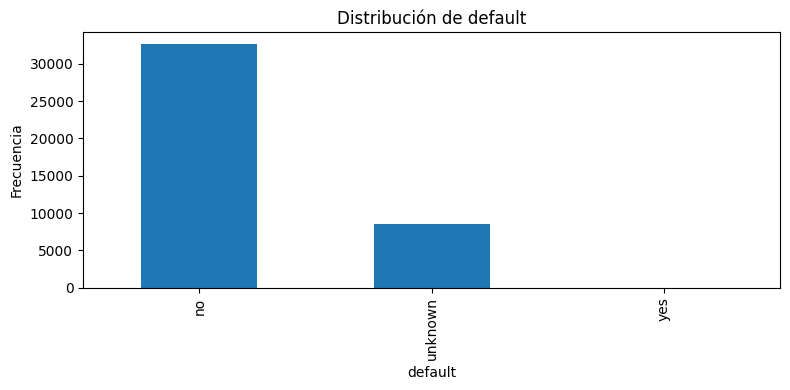

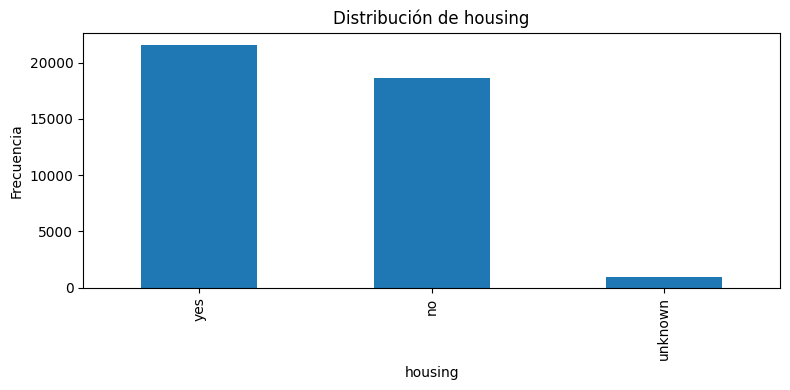

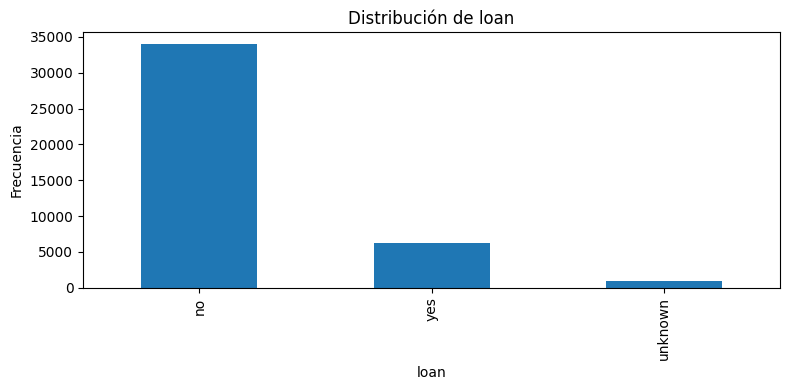

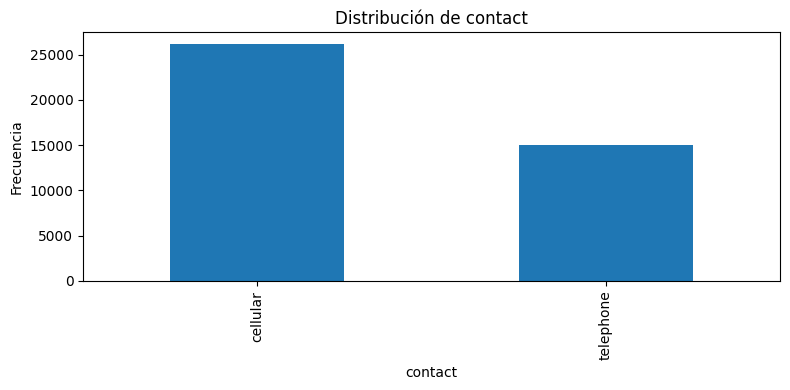

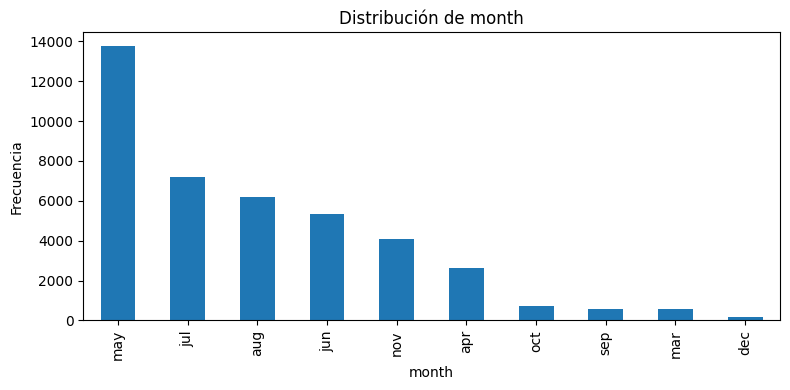

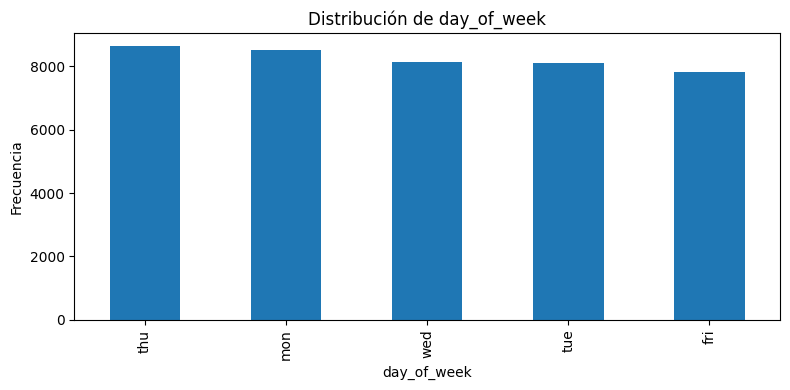

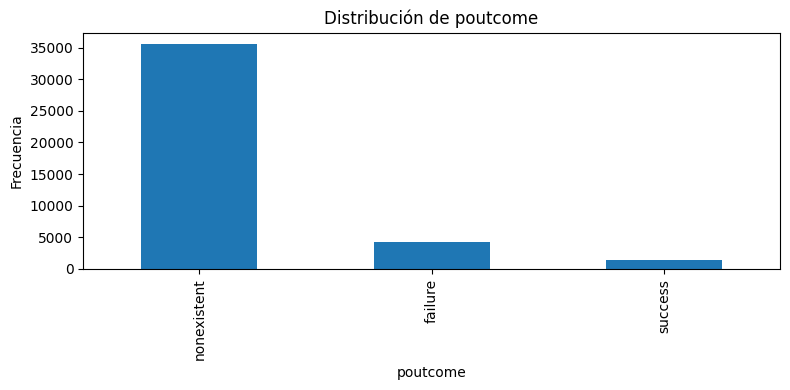

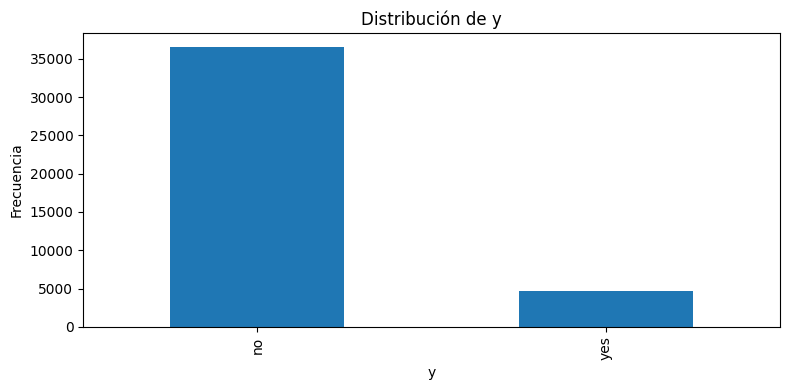

In [618]:
# Seleccionamos columnas categóricas
cat_cols = df_eda.select_dtypes(include=['object']).columns.tolist()
print("Columnas categóricas a analizar:", cat_cols)

for col in cat_cols:
    n_unique = df_eda[col].nunique(dropna=True)

    # Agrupar en "Otros" si hay muchas categorías
    if n_unique > 10:
        print(f"'{col}' tiene {n_unique} categorías -> se muestra top 10 + 'Otros'.")
        top_counts = df_eda[col].value_counts().nlargest(10)
        others_count = df_eda[col].value_counts().iloc[10:].sum()
        counts = pd.concat([top_counts, pd.Series({'Otros': others_count})])
    else:
        counts = df_eda[col].value_counts()

    if counts.size <= 1:
        print(f"Se omite '{col}' (sin variabilidad).")
        continue

    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

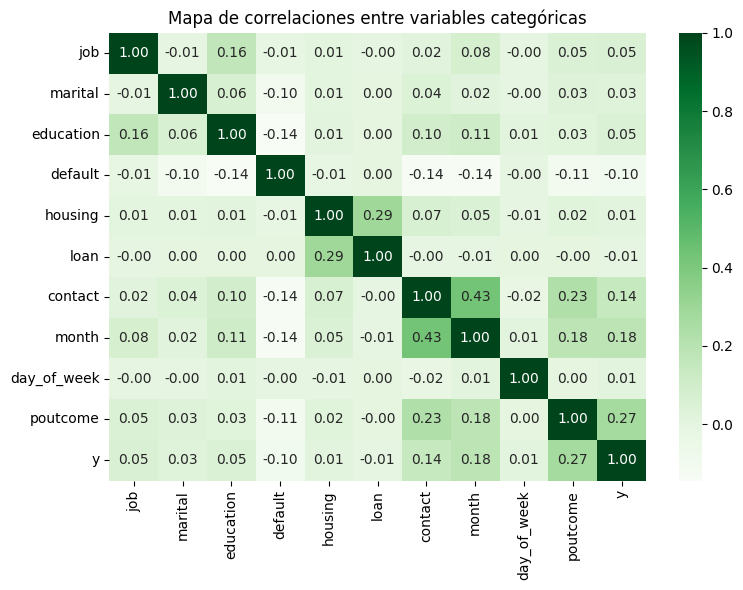

In [619]:
corr_cat = df_eda[cat_cols].apply(lambda x: pd.factorize(x)[0]).corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_cat, annot=True, cmap='Greens', fmt=".2f")
plt.title("Mapa de correlaciones entre variables categóricas")
plt.tight_layout()
plt.show()

## 4. Análisis multivariante

Relación entre las variables y el objetivo (`y`)

A continuación analizamos cómo se relacionan las características de los clientes
con la variable objetivo (`y`), es decir, si contratan o no el depósito.

En particular:

- Para **variables numéricas**, comparamos la distribución de cada variable entre clientes que responden "yes" y "no"
  (mediante histogramas/KDE con `hue='y'` y boxplots por clase).

- Para **variables categóricas**, calculamos la **tasa de respuesta** (media de `y_n`) por categoría
  y la representamos mediante gráficos de barras.

- En algunos casos, como la **edad**, creamos rangos (`bins`) y analizamos la probabilidad de respuesta por tramo,
  lo que facilita la interpretación desde el punto de vista de segmentos de clientes.


### 4.1 Relación entre "y" y variables numericas

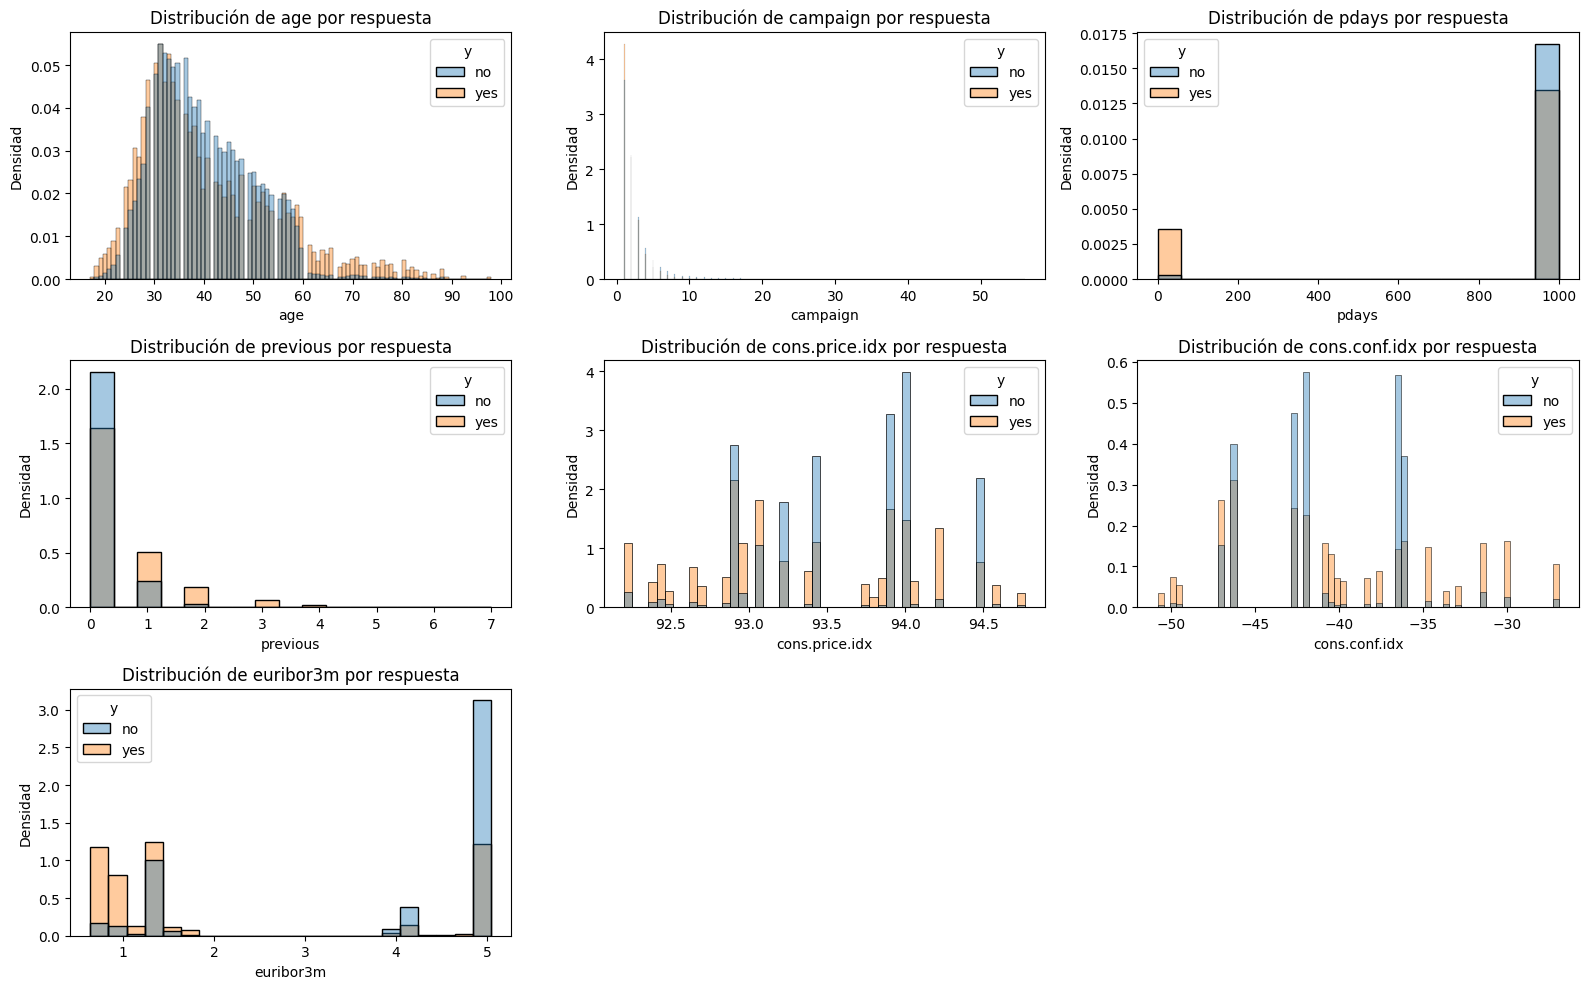

In [620]:
num_vars = ["age", "campaign", "pdays", "previous", "cons.price.idx", "cons.conf.idx", "euribor3m"]

fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    ax = axes[i]
    sns.histplot(
        data=df_eda,
        x=col,
        hue="y",             # 'yes' / 'no'
        stat="density",
        common_norm=False,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f"Distribución de {col} por respuesta")
    ax.set_xlabel(col)
    ax.set_ylabel("Densidad")

# Elimina ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


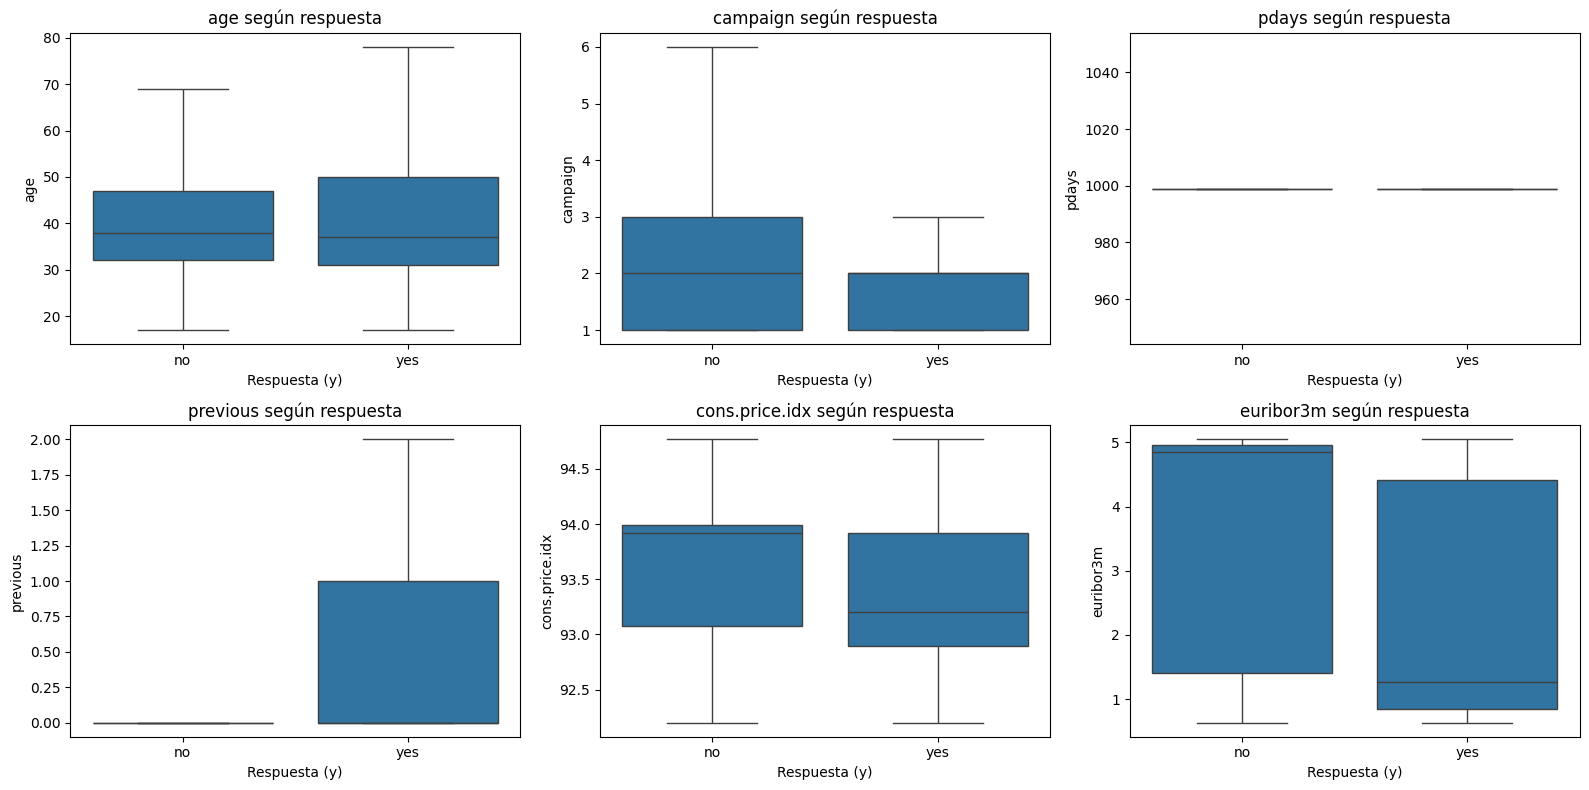

In [621]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(["age", "campaign", "pdays", "previous", "cons.price.idx", "euribor3m"]):
    sns.boxplot(
        data=df_eda,
        x="y",
        y=col,
        ax=axes[i],
        showfliers=False
    )
    axes[i].set_title(f"{col} según respuesta")
    axes[i].set_xlabel("Respuesta (y)")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

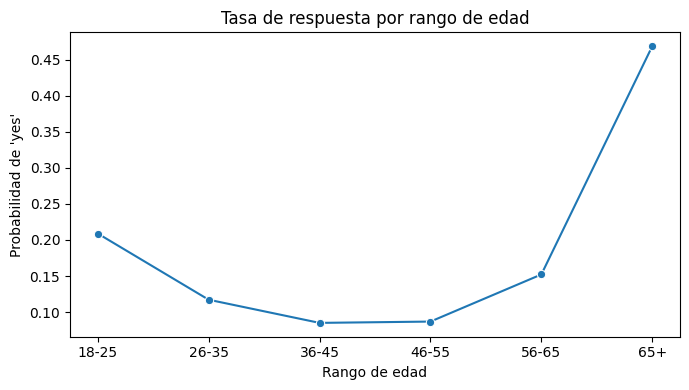

In [622]:
df_eda["age_bin"] = pd.cut(df_eda["age"],
                           bins=[17, 25, 35, 45, 55, 65, 100],
                           labels=["18-25", "26-35", "36-45", "46-55", "56-65", "65+"])

age_rate = (
    df_eda.groupby("age_bin")["y_n"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7, 4))
sns.lineplot(data=age_rate, x="age_bin", y="y_n", marker="o")
plt.title("Tasa de respuesta por rango de edad")
plt.xlabel("Rango de edad")
plt.ylabel("Probabilidad de 'yes'")
plt.tight_layout()
plt.show()

### 4.2 Relación entre "y" y variables categoricas

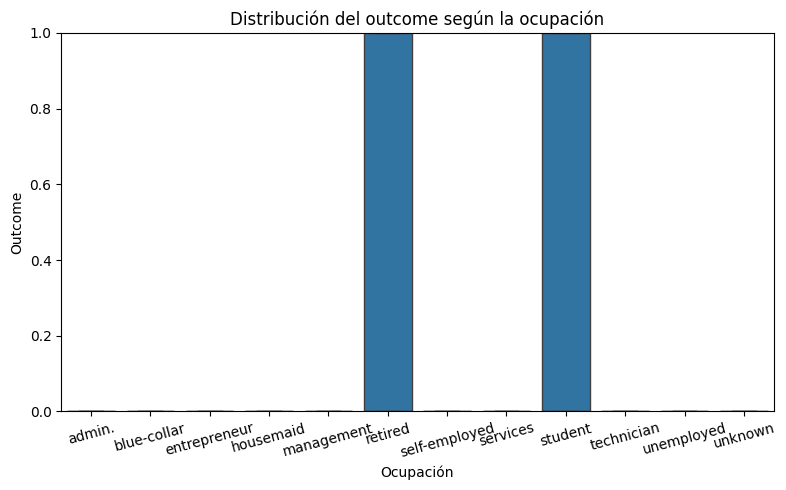

In [623]:
plt.figure(figsize=(8, 5))

order = df_eda.groupby('job')['y_n'].median().sort_values().index
y_max = np.percentile(df_eda['y_n'], 95)  # limitar eje Y

sns.boxplot(
    data=df_eda,
    x='job',
    y='y_n',
    order=order,
    showfliers=False
)

plt.ylim(0, y_max)
plt.title("Distribución del outcome según la ocupación")
plt.xlabel("Ocupación")
plt.ylabel("Outcome")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

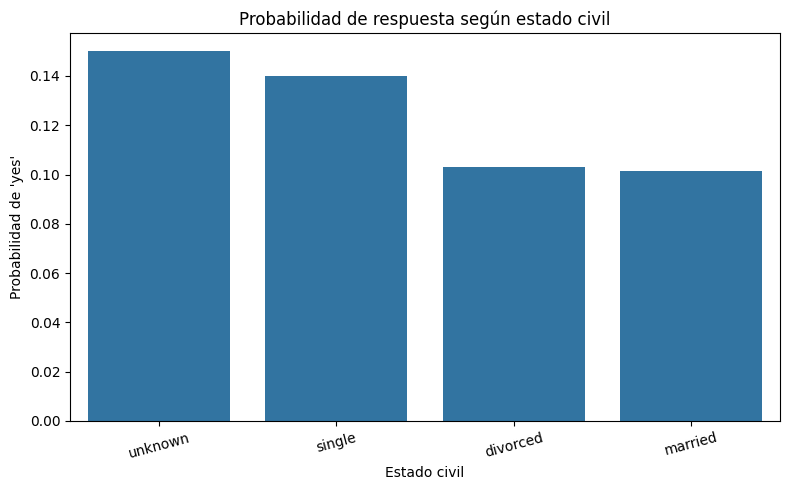

In [624]:
plt.figure(figsize=(8, 5))

marital_rate = (df_eda.groupby('marital')['y_n'].mean().sort_values(ascending=False).reset_index())

sns.barplot(
    data=marital_rate,
    x='marital',
    y='y_n'
)

plt.title("Probabilidad de respuesta según estado civil")
plt.ylabel("Probabilidad de 'yes'")
plt.xlabel("Estado civil")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

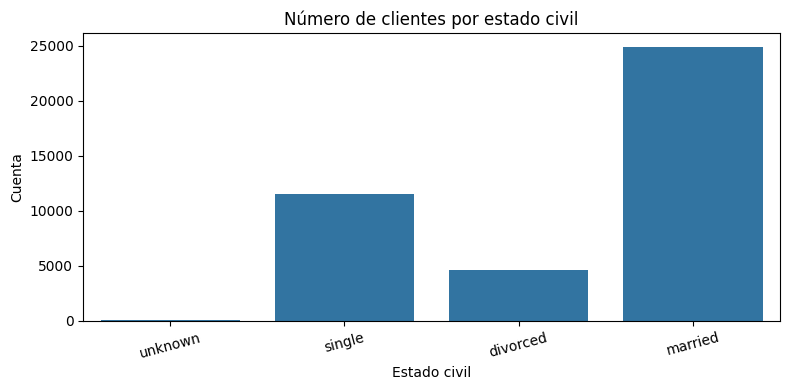

In [625]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_eda, x="marital", order=marital_rate["marital"])
plt.title("Número de clientes por estado civil")
plt.xlabel("Estado civil")
plt.ylabel("Cuenta")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

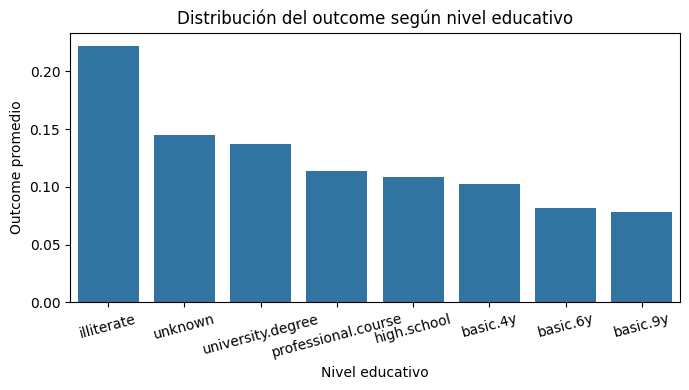

In [626]:
plt.figure(figsize=(7, 4))

education = (
    df_eda.groupby('education')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=education,
    x='education',
    y='y_n'
)

plt.title("Distribución del outcome según nivel educativo")
plt.ylabel("Outcome promedio")
plt.xlabel("Nivel educativo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

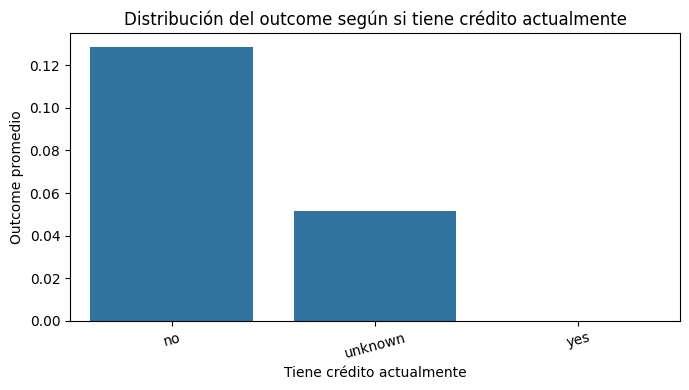

In [627]:
plt.figure(figsize=(7, 4))

default = (
    df_eda.groupby('default')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=default,
    x='default',
    y='y_n'
)

plt.title("Distribución del outcome según si tiene crédito actualmente")
plt.ylabel("Outcome promedio")
plt.xlabel("Tiene crédito actualmente")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

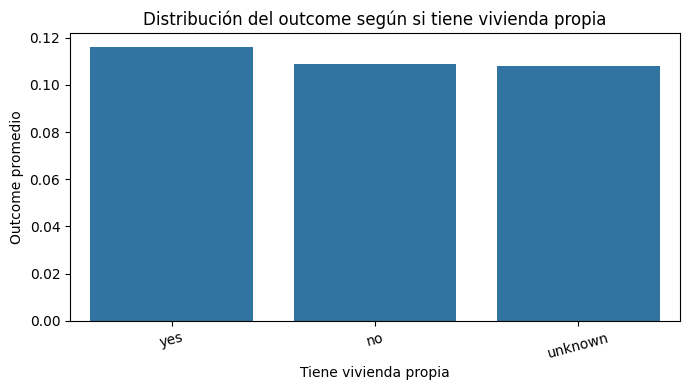

In [628]:
plt.figure(figsize=(7, 4))

housing = (
    df_eda.groupby('housing')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=housing,
    x='housing',
    y='y_n'
)

plt.title("Distribución del outcome según si tiene vivienda propia")
plt.ylabel("Outcome promedio")
plt.xlabel("Tiene vivienda propia")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

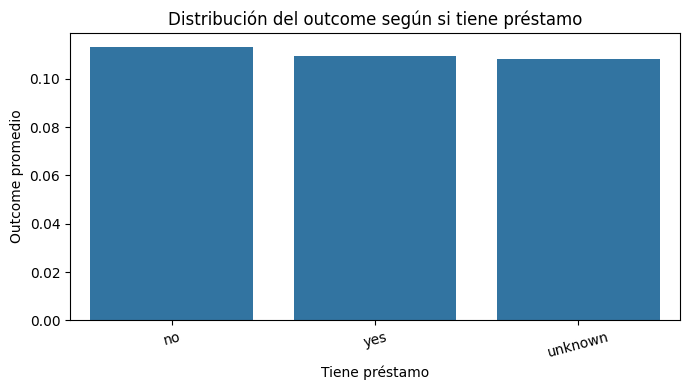

In [629]:
plt.figure(figsize=(7, 4))

loan = (
    df_eda.groupby('loan')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=loan,
    x='loan',
    y='y_n'
)

plt.title("Distribución del outcome según si tiene préstamo")
plt.ylabel("Outcome promedio")
plt.xlabel("Tiene préstamo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

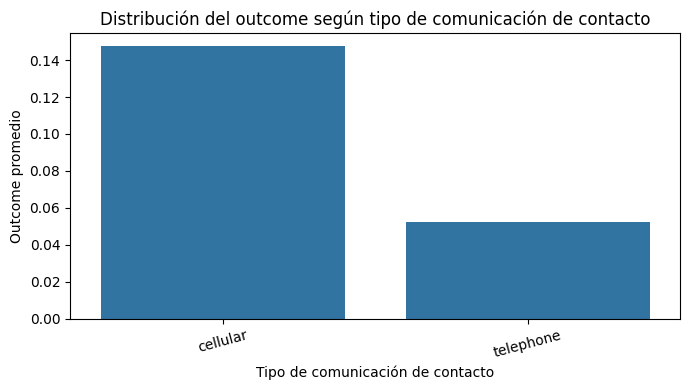

In [630]:
plt.figure(figsize=(7, 4))

contact = (
    df_eda.groupby('contact')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=contact,
    x='contact',
    y='y_n'
)

plt.title("Distribución del outcome según tipo de comunicación de contacto")
plt.ylabel("Outcome promedio")
plt.xlabel("Tipo de comunicación de contacto")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

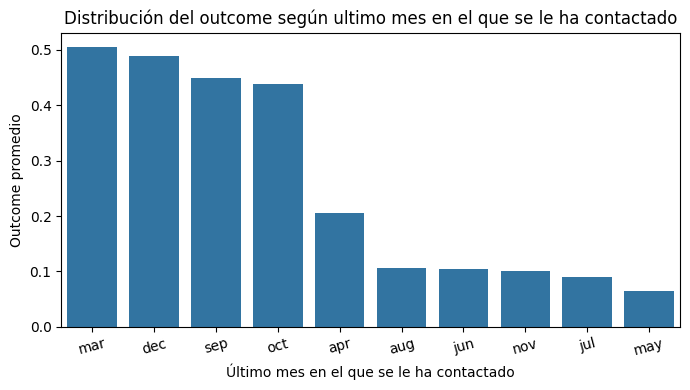

In [631]:
plt.figure(figsize=(7, 4))

month = (
    df_eda.groupby('month')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=month,
    x='month',
    y='y_n'
)

plt.title("Distribución del outcome según ultimo mes en el que se le ha contactado")
plt.ylabel("Outcome promedio")
plt.xlabel("Último mes en el que se le ha contactado")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

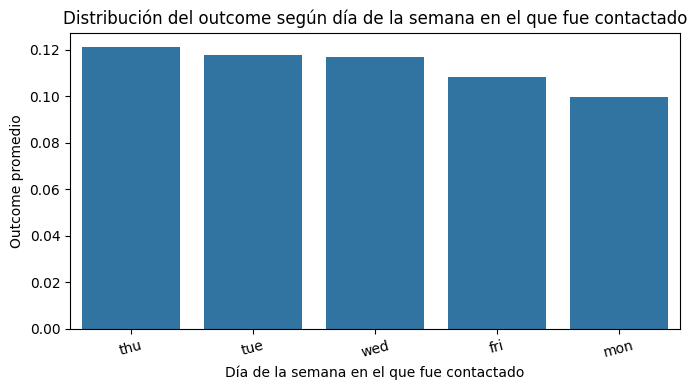

In [632]:
plt.figure(figsize=(7, 4))

day_of_week = (
    df_eda.groupby('day_of_week')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=day_of_week,
    x='day_of_week',
    y='y_n'
)

plt.title("Distribución del outcome según día de la semana en el que fue contactado")
plt.ylabel("Outcome promedio")
plt.xlabel("Día de la semana en el que fue contactado")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

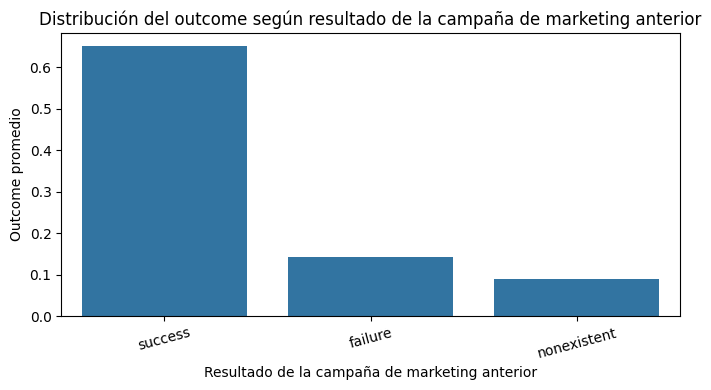

In [633]:
plt.figure(figsize=(7, 4))

poutcome = (
    df_eda.groupby('poutcome')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=poutcome,
    x='poutcome',
    y='y_n'
)

plt.title("Distribución del outcome según resultado de la campaña de marketing anterior")
plt.ylabel("Outcome promedio")
plt.xlabel("Resultado de la campaña de marketing anterior")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [634]:
pd.crosstab(df_eda["poutcome"], df_eda["y"], normalize="index")


y,no,yes
poutcome,,
failure,0.857714,0.142286
nonexistent,0.911678,0.088322
success,0.348871,0.651129


In [635]:
# Distribución de la variable objetivo

df_eda["y"].value_counts(normalize=False)

df_eda["y"].value_counts(normalize=True) * 100

y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

## 5. Preparación de los datos para el modelado

Para entrenar el modelo de Regresión Logística:

1. Definimos la variable objetivo `y` como un indicador binario (`1` = "yes", `0` = "no").
2. Separamos los datos en conjuntos de entrenamiento y prueba (`train_test_split`) con estratificación según `y`,
   para mantener la proporción de clases.
3. Aplicamos **one-hot encoding** a las variables categóricas mediante `pd.get_dummies`.
4. Escalamos las variables numéricas con `StandardScaler`, ya que la Regresión Logística es sensible a la escala
   de las features.

Este proceso nos deja una matriz de características numéricas lista para ser utilizada por el modelo.

In [636]:
#  Preparación del dataframe para modelado

df_model = df.copy()   # partimos del df ya sin duration, emp.var.rate y nr.employed


In [637]:
# Target

y = df_model["y"].map({"no": 0, "yes": 1})

# Features

X = df_model.drop(columns=["y"])

In [638]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(X_train.shape, X_test.shape)

(32950, 17) (8238, 17)


In [639]:
# 1. Identificar columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

print("Columnas categóricas:", cat_cols)
print("Columnas numéricas:", num_cols)

# 2. One-hot encoding
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# 3. Alinear columnas entre train y test
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Shape X_train_enc:", X_train_enc.shape)
print("Shape X_test_enc :", X_test_enc.shape)

# 4. Escalado de numéricas
scaler = StandardScaler()

X_train_scaled = X_train_enc.copy()
X_test_scaled  = X_test_enc.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test_scaled[num_cols])


Columnas categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Columnas numéricas: ['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
Shape X_train_enc: (32950, 50)
Shape X_test_enc : (8238, 50)


## 6. Entrenamiento y evaluación del modelo de Regresión Logística

Entrenamos un modelo base de Regresión Logística con los datos preparados y evaluamos su rendimiento en el
conjunto de prueba.

Las métricas que analizamos son:

- **Accuracy**: proporción de aciertos totales.
- **Matriz de confusión**: distribución de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
- **Precision, Recall y F1-score** para cada clase (especialmente la clase positiva "yes").

Posteriormente utilizamos `GridSearchCV` para ajustar hiperparámetros clave (como `C`, `penalty` y `class_weight`)
y seleccionamos el mejor modelo según validación cruzada.

In [640]:
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE
)

log_reg.fit(X_train_scaled, y_train)

y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test  = log_reg.predict(X_test_scaled)

print("Accuracy train:", accuracy_score(y_train, y_pred_train))
print("Accuracy test :", accuracy_score(y_test,  y_pred_test))

print("\nMatriz de confusión (test):")
print(confusion_matrix(y_test, y_pred_test))

print("\nClassification report (test):")
print(classification_report(y_test, y_pred_test))

Accuracy train: 0.9001820940819424
Accuracy test : 0.9004612770089827

Matriz de confusión (test):
[[7197  113]
 [ 707  221]]

Classification report (test):
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7310
           1       0.66      0.24      0.35       928

    accuracy                           0.90      8238
   macro avg       0.79      0.61      0.65      8238
weighted avg       0.88      0.90      0.88      8238



In [641]:

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
    "class_weight": [None, "balanced"],
    "solver": ["liblinear"]     # soporta L1 y L2
}

base_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE
)

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score CV:", grid.best_score_)

best_model = grid.best_estimator_


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: p

Mejores hiperparámetros: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor score CV: 0.9


In [642]:
y_pred_best = best_model.predict(X_test_scaled)

print("Accuracy (best model) test:", accuracy_score(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Accuracy (best model) test: 0.8998543335761107
[[7197  113]
 [ 712  216]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7310
           1       0.66      0.23      0.34       928

    accuracy                           0.90      8238
   macro avg       0.78      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238



In [643]:
coef_df = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "coef": best_model.coef_[0]
})

coef_df["odds_ratio"] = np.exp(coef_df["coef"])

coef_df.sort_values("odds_ratio", ascending=False).head(15)

,feature,coef,odds_ratio
39,month_mar,0.919992,2.509270
49,poutcome_success,0.433455,1.542579
48,poutcome_nonexistent,0.317228,1.373315
4,cons.price.idx,0.295690,1.344053
11,job_retired,0.214322,1.239022
5,cons.conf.idx,0.203983,1.226278
14,job_student,0.162650,1.176625
37,month_jul,0.137724,1.147658
47,day_of_week_wed,0.070691,1.073249
38,month_jun,0.029508,1.029948


## 7. Interpretación de resultados y conclusiones de negocio

A partir de los coeficientes del modelo de Regresión Logística calculamos los **odds ratios**
para interpretar el impacto de cada variable en la probabilidad de que un cliente contrate el depósito.

Esto nos permite responder preguntas como:

- ¿Qué tipo de contacto (teléfono móvil, fijo, etc.) está más asociado con una respuesta positiva?
- ¿Influye el resultado de campañas anteriores (`poutcome`)?
- ¿Existen segmentos de edad con mayor probabilidad de aceptar la oferta?

Finalmente, resumimos las principales conclusiones:

- Variables más relevantes para predecir la respuesta.
- Segmentos de clientes más propensos a contratar el producto.
- Posibles recomendaciones para futuras campañas de marketing (por ejemplo, a quién priorizar, qué canales usar,
  en qué meses concentrar los contactos, etc.).

In [644]:
tree_clf = DecisionTreeClassifier(
    max_depth=5,
    random_state=RANDOM_STATE
)

tree_clf.fit(X_train_scaled, y_train)
y_pred_tree = tree_clf.predict(X_test_scaled)

print("Accuracy árbol:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))


Accuracy árbol: 0.8988832240835154
[[7156  154]
 [ 679  249]]


In [645]:

# Guardar modelo
with open("../models/logistic_regression_best.pkl", "wb") as f:
    dump(best_model, f)

# Guardar scaler
with open("../models/scaler.pkl", "wb") as f:
    dump(scaler, f)

# Guardar columnas usadas
with open("../data/processed/model_features.json", "w") as f:
    json.dump(list(X_train_scaled.columns), f)


In [646]:
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",16
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi